<a href="https://colab.research.google.com/github/amrahmani/NN/blob/main/Ch6_AutoEncoder_MNIST_HandWrittenDigits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem: MNIST dataset of handwritten digits**

Create an autoencoder using PyTorch to compress and reconstruct images from the MNIST dataset. The autoencoder should reduce the dimensionality of the 28x28 pixel images, encode them into a lower-dimensional space, and then decode them back to their original dimensions. Train the model on the MNIST training set, and evaluate its performance by visualizing the reconstructed images from the test set.

**Hyperparameters and Data Loading**

In [34]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Transformations applied to the dataset
transform = transforms.Compose([
    transforms.ToTensor(),          # Convert images to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the tensor values to mean 0.5 and std 0.5
])

# Load the MNIST training dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
# Load the MNIST test dataset
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create data loaders for training and testing
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)  # batch_size = 64       # Number of samples per batch
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

**Autoencoder Definition**

In [30]:
# Define the autoencoder model
class MNIST_Autoencoder(nn.Module):
    def __init__(self):
        super(MNIST_Autoencoder, self).__init__()
        # Encoder: linear layers with ReLU activations to reduce dimensions
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), # Input layer to hidden layer
            nn.ReLU(),               # Activation function
            nn.Linear(128, 60),      # Hidden layer to another hidden layer
            nn.ReLU(),               # Activation function
            nn.Linear(60, 30),       # Final hidden layer to latent space
            nn.ReLU()                # Activation function
        )
        # Decoder: linear layers with ReLU and Sigmoid activations to reconstruct data
        self.decoder = nn.Sequential(
            nn.Linear(30, 60),       # Latent space to hidden layer
            nn.ReLU(),               # Activation function
            nn.Linear(60, 128),      # Hidden layer to another hidden layer
            nn.ReLU(),               # Activation function
            nn.Linear(128, 28 * 28), # Final hidden layer to output layer
            nn.Tanh()                # Tanh activation to get output in range [-1, 1]. why we don't use Sigmoid?
        )

    def forward(self, x):
        # Define forward pass: encoding and then decoding
        x = self.encoder(x)
        x = self.decoder(x)
        return x

**Training the Autoencoder**

In [31]:
# Hyperparameters
learning_rate = 0.001 # Learning rate for the optimizer
num_epochs = 5        # Number of epochs to train the model

# Initialize the autoencoder model
autoencoder = MNIST_Autoencoder()
# Define the loss function (mean squared error)
criterion = nn.MSELoss()
# Define the optimizer (Adam) with the model's parameters and learning rate
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

# Training the autoencoder
for epoch in range(num_epochs):
    for data in train_loader:
        inputs, _ = data                  # Get inputs; labels are not needed for autoencoders
        inputs = inputs.view(-1, 28 * 28) # Flatten the images into a 1D vector of 784 elements

        # Forward pass: compute the model output
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs) # Compute the loss (error)

        # Backward pass and optimization
        optimizer.zero_grad() # Zero the gradients
        loss.backward()       # Backpropagate the loss
        optimizer.step()      # Update the model parameters

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}') # Print loss for the current epoch

Epoch [1/5], Loss: 0.1097
Epoch [2/5], Loss: 0.0756
Epoch [3/5], Loss: 0.0593
Epoch [4/5], Loss: 0.0641
Epoch [5/5], Loss: 0.0505


**Testing and Visualization**

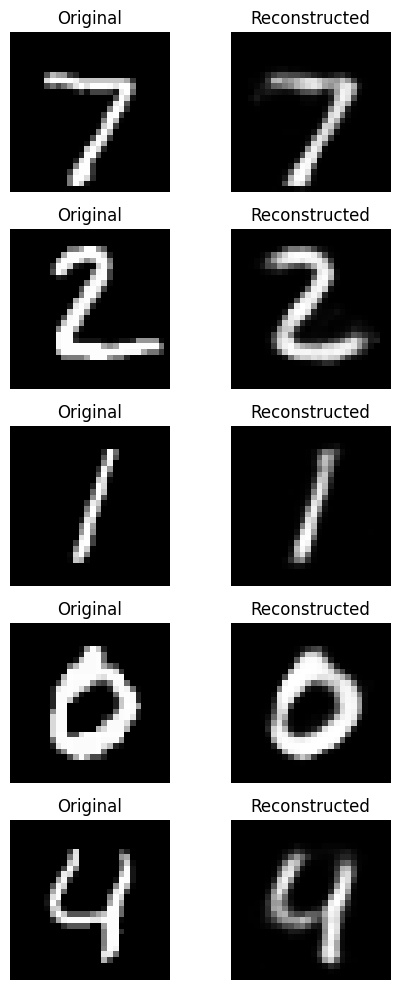

In [33]:
# Testing the autoencoder with a fixed number of test samples
num_test_samples = 5  # Number of test samples to visualize
test_iterator = iter(test_loader)  # Create an iterator for the test loader

with torch.no_grad():  # Disable gradient calculation for inference
    inputs, _ = next(test_iterator)  # Get a batch of test data
    inputs = inputs.view(-1, 28 * 28)  # Flatten the images into a 1D vector of 784 elements
    outputs = autoencoder(inputs)  # Get reconstructed outputs from the model

    # Reshape the inputs and outputs for visualization
    inputs = inputs.view(-1, 1, 28, 28)[:num_test_samples]
    outputs = outputs.view(-1, 1, 28, 28)[:num_test_samples]

    # Display the original and reconstructed images

    fig, axes = plt.subplots(num_test_samples, 2, figsize=(5, num_test_samples * 2))  # Create a figure with 2 columns
    for i in range(num_test_samples):
        axes[i, 0].imshow(inputs[i].squeeze(), cmap='gray')  # Display the original image
        axes[i, 0].set_title('Original')  # Set title for the original image
        axes[i, 0].axis('off')  # Hide axes
        axes[i, 1].imshow(outputs[i].squeeze(), cmap='gray')  # Display the reconstructed image
        axes[i, 1].set_title('Reconstructed')  # Set title for the reconstructed image
        axes[i, 1].axis('off')  # Hide axes
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()  # Show the plot